In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import math

Nils Winkler, nilschristian.winkler@uzh.ch

Eleonora Salcuni, salcunieleonora00@gmail.com

Petrit Bllaca, petrit.bllc@gmail.com

# 1) Generating IR and FX+EQ Paths

In [2]:
def simulate_gbm_fx_eq(mu, sigma, rho, X0, T, Nsteps, Npaths):

    mu    = np.asarray(mu)
    sigma = np.asarray(sigma)
    X0    = np.asarray(X0)

    dt = T / Nsteps
    # Correlation
    L = np.array([[1.0,    0.0],
                  [rho, np.sqrt(1 - rho**2)]])

    # Allocate: 2 factors × Npaths × (Nsteps+1)
    X = np.zeros((2, Npaths, Nsteps))
    X[:, :, 0] = X0[:, np.newaxis]    # shape (2,1) → broadcast to (2,Npaths)

    # Precompute the “drift” term as a column‑vector
    drift = ((mu - 0.5*sigma**2) * dt)[:, np.newaxis]   # now shape (2,1)
    diffusion_coeff = (sigma * np.sqrt(dt))[:, np.newaxis]  # shape (2,1)

    for k in range(Nsteps-1):
        U = np.random.randn(2, Npaths)    # shape (2, Npaths)
        Z = L @ U                         # correlated normals, shape (2, Npaths)

        # now drift + diffusion_coeff * Z both are (2, Npaths)
        X[:, :, k+1] = X[:, :, k] * np.exp(drift + diffusion_coeff * Z)

    return X



def simulate_vasicek(a, b, sigma_r, r0, T, Nsteps, Npaths):
    dt = T / Nsteps
    r = np.zeros((Npaths, Nsteps))
    r[:,0] = r0
    sqrt_term = lambda dt: np.sqrt((1-np.exp(-2*a*dt))/(2*a))
    for k in range(Nsteps-1):
        Z = np.random.randn(Npaths)
        r[:,k+1] = (r[:,k]*np.exp(-a*dt)
                    + b*(1-np.exp(-a*dt))
                    + sigma_r*sqrt_term(dt)*Z)
    return r

mu    = [0.08, 0.08]        # drifts for equity, FX
sigma = [0.20, 0.20]        # vols
rho   = 0.3
X0    = [100.0, 1.0]
T     = 1.0; Nsteps = 100; Npaths = 1_000

X = simulate_gbm_fx_eq(mu, sigma, rho, X0, T, Nsteps, Npaths)
r = simulate_vasicek(a=0.1, b=0.03, sigma_r=0.01, r0=0.03,
                     T=T, Nsteps=Nsteps, Npaths=Npaths)
S = X[0]
FX = X[1]

# 2a) BS Call Price and Greeks using Backward Mode

In [3]:
def bs_call_backward(S, times, T, K, r, sigma, C_b):
    """
    Black–Scholes call price + reverse‑mode adjoints w.r.t. S, K, r, σ.

    S : ndarray, shape (n_paths, n_times)
    times : 1D array of time points from 0 to T
    T : float, maturity
    K : float, strike
    r : scalar or array (n_times,) or (n_paths, n_times)
    sigma : float, volatility
    C_b : scalar or array, adjoint weights

    Returns:
    C : ndarray, (n_paths, n_times)
    greeks : dict with keys 'dS0','dr','dsigma'
    """
    S = np.asarray(S)
    n_paths, n_times = S.shape

    # check times
    times = np.asarray(times)
    if times.ndim != 1 or times.size != n_times:
        raise ValueError(f"times must be 1D of length {n_times}")
    #if not np.isclose(times[0], 0) or not np.isclose(times[-1], T):
    #    raise ValueError("times must span from 0 to T")

    # broadcast r
    r_arr = np.asarray(r)
    if r_arr.ndim == 0:
        r_mat = np.full_like(S, r_arr)
    elif r_arr.ndim == 1 and r_arr.size == n_times:
        r_mat = np.tile(r_arr, (n_paths, 1))
    elif r_arr.shape == (n_paths, n_times):
        r_mat = r_arr
    else:
        raise ValueError(f"r must be scalar or shape ({n_times},) or ({n_paths},{n_times})")

    # broadcast C_b
    Cb_arr = np.asarray(C_b)
    if Cb_arr.ndim == 0:
        Cb_mat = np.full_like(S, Cb_arr)
    else:
        Cb_mat = Cb_arr

    # time-to-maturity
    tau = T - times                         # (n_times,)
    tau_mat = np.tile(tau, (n_paths, 1))   # (n_paths,n_times)
    valid = tau_mat > 0
    sqrt_tau = np.sqrt(np.where(valid, tau_mat, 1.0))

    # forward pass
    ln = np.log(S / K)
    d1_nom = ln + (r_mat + 0.5*sigma**2)*tau_mat
    d1_den = sigma * sqrt_tau
    d1 = np.zeros_like(S)
    d2 = np.zeros_like(S)
    d1[valid] = d1_nom[valid] / d1_den[valid]
    d2[valid] = d1[valid] - d1_den[valid]

    N1 = norm.cdf(d1)
    N2 = norm.cdf(d2)
    disc = np.exp(-r_mat * tau_mat)

    C = np.zeros_like(S)
    C[valid] = S[valid]*N1[valid] - K*disc[valid]*N2[valid]
    C[~valid] = np.maximum(S[~valid] - K, 0)

    # reverse pass
    S_b = np.zeros_like(S)
    K_b = np.zeros_like(S)
    r_b = np.zeros_like(S)
    sigma_b = np.zeros_like(S)
    tau_b = np.zeros_like(S)

    # payoff at maturity
    S_b[~valid] = (S[~valid] > K).astype(float)
    K_b[~valid] = -S_b[~valid]

    Cb = Cb_mat
    S_b[valid] += N1[valid]*Cb[valid]
    N1_b = np.zeros_like(S); N1_b[valid] = S[valid]*Cb[valid]

    K_b[valid] += -disc[valid]*N2[valid]*Cb[valid]
    disc_b = np.zeros_like(S); disc_b[valid] = -K*N2[valid]*Cb[valid]
    N2_b = np.zeros_like(S); N2_b[valid] = -K*disc[valid]*Cb[valid]

    r_b[valid]   += -tau_mat[valid]*disc[valid]*disc_b[valid]
    tau_b[valid] += -r_mat[valid]*disc[valid]*disc_b[valid]

    pdf1 = norm.pdf(d1)
    pdf2 = norm.pdf(d2)
    d2_b = np.zeros_like(S); d2_b[valid] = pdf2[valid]*N2_b[valid]
    d1_b = np.zeros_like(S); d1_b[valid] = pdf1[valid]*N1_b[valid]

    # chain d2 = d1 - d1_den
    d1_b[valid]    += d2_b[valid]
    d1_den_b       = np.zeros_like(S); d1_den_b[valid] = -d2_b[valid]

    # chain d1 = d1_nom/d1_den
    d1_nom_b       = np.zeros_like(S); d1_nom_b[valid] = d1_b[valid]/d1_den[valid]
    d1_den_b[valid] += -d1_nom[valid]/(d1_den[valid]**2)*d1_b[valid]

    # d1_den = sigma*sqrt_tau
    sigma_b[valid] += sqrt_tau[valid]*d1_den_b[valid]
    sqrt_tau_b     = np.zeros_like(S); sqrt_tau_b[valid] = sigma*d1_den_b[valid]

    # d1_nom = ln + (r+0.5σ²)*τ
    ln_b           = np.zeros_like(S); ln_b[valid] = d1_nom_b[valid]
    r_b[valid]     += tau_mat[valid]*d1_nom_b[valid]
    sigma_b[valid] += sigma*tau_mat[valid]*d1_nom_b[valid]
    tau_b[valid]   += (r_mat[valid]+0.5*sigma**2)*d1_nom_b[valid]

    # ln = log(S/K)
    S_b[valid] += (1/S[valid])*ln_b[valid]
    K_b[valid] += (-1/K)*ln_b[valid]

    # sqrt_tau = sqrt(tau)
    tau_b[valid] += 0.5/sqrt_tau[valid]*sqrt_tau_b[valid]

    greeks = {'dS0': S_b, 'dr': r_b, 'dsigma': sigma_b}
    return C, greeks


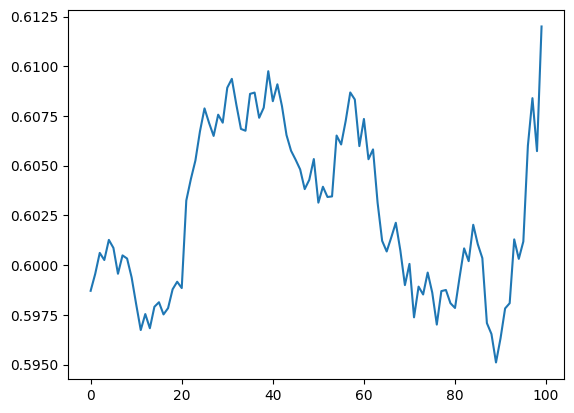

In [4]:
C, greeks = bs_call_backward(S, np.linspace(0,1,100), 1, 100, 0.03, 0.2, 1)
plt.plot(greeks['dS0'].mean(axis=0))

# 2b) FX Barrier Price and Greeks using Monte Carlo with Tangent Mode and Brownian Bridge Method

I clipped the factor by c*h because otherwise we have a vanishing gradient for higher barriers B. The problem is that this clipping factor c is an external parameter which needs to be chosen, but compared to the method in 2c) it has much lower variance and is much faster. It also requires way less MC simulations to converge.

In [5]:
def fx_barrier_mc_tang_bb(
    S0, times, T, K, B, r, sigma,
    Nsim=20000, option_type="up-and-in"
):
    """
    MC up‑and‑in barrier call pricer with full pathwise tangents:
      - delta    = ∂/∂S0
      - rho      = ∂/∂r
      - vega     = ∂/∂σ
      - strike‑delta = ∂/∂K
      - barrier‑delta = ∂/∂B via one‑step survival tangent
    Returns: price, {dS0, dr, dsigma, dK, dB}
    """
    M  = len(times)
    t0 = times[0]
    h  = (T - t0)/(M-1)

    # 1) simulate Brownian increments
    dW = np.random.normal(0, np.sqrt(h), size=(Nsim, M-1))

    # 2) allocate arrays
    S         = np.zeros((Nsim, M))
    Tng       = np.zeros((Nsim, M, 4))   # tangents for [S0,r,σ,K]
    logW_surv = np.zeros(Nsim)           # sum of log survival–probs
    dlogW_dB  = np.zeros(Nsim)           # ∂ logW_surv / ∂B

    # 3) initial conditions
    S[:,0]     = S0
    Tng[:,0,0] = 1.0   # ∂S/∂S0 = 1 at t0

    # mask of “still alive” (never crossed up to previous step)
    alive = np.ones(Nsim, dtype=bool)

    # 4) forward loop
    for i in range(M-1):
        Si   = S[:,i]
        Zi   = dW[:,i]
        # exact GBM update
        A    = (r - 0.5*sigma**2)*h + sigma*Zi
        Mfac = np.exp(A)
        Sip1 = Si * Mfac
        S[:,i+1] = Sip1

        # 4a) pathwise tangents for S0, r, sigma, K
        Tprev = Tng[:,i,:]
        Tng[:,i+1,0] = Mfac * Tprev[:,0]                    # ∂S/∂S0
        Tng[:,i+1,1] = Mfac * (Tprev[:,1] + Si*h)           # ∂S/∂r
        Tng[:,i+1,2] = Mfac * (Tprev[:,2] + Si*(Zi - sigma*h))  # ∂S/∂σ
        #Tng[:,i+1,3] = Mfac * Tprev[:,3]                    # ∂S/∂K = 0 always

        # 4b) update “alive” mask: must stay below barrier this step
        still = (Si < B) & (Sip1 < B)
        alive = alive & still

        # 4c) build per‑step log‑hit‑prob κ_i and its ∂/∂B
        idx = np.nonzero(alive)[0]
        step_logp = np.full(Nsim, -np.inf)  # default: p_hit=0 when dead
        step_dlp  = np.zeros(Nsim)
        if len(idx):
            lnBi   = np.log(B) - np.log(Si[idx])
            lnBip  = np.log(B) - np.log(Sip1[idx])
            # log of hit‐prob
            step_logp_i = -2 * lnBi * lnBip / (sigma**2 * h)
            step_logp[idx] = step_logp_i
            # derivative of κ_i w.r.t. B
            step_dlp[idx] = -2*(lnBi + lnBip)/(B * sigma**2 * h)

        # 4d) convert to one‐step survival and accumulate
        p_hit   = np.exp(step_logp)
        # clip to avoid exactly 0 or 1 to avoid an error
        #eps     = 1e-2
        #p_hit   = np.minimum(np.maximum(p_hit, eps), 1-eps)
        p_surv_i= 1.0 - p_hit

        # accumulate log‑survival and its tangent
        logW_surv += np.log(p_surv_i)

        #!!!!!!!!!!!!!!!!!!!!!! CLIPPED THE FACTOR TO AVOID VANISHING GRADIENT PROBLEM !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        factor = np.clip(p_hit/p_surv_i,h,10000)
        dlogW_dB  += - factor * step_dlp
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    # 5) build final survival/hit weights and B‑tangent
    if S0>=B:
      W_surv = np.zeros_like(logW_surv)
    else:
      W_surv     = np.exp(logW_surv)
    dW_surv_dB = W_surv * dlogW_dB
    W_hit      = 1.0 - W_surv
    dW_hit_dB  = -dW_surv_dB

    # 6) payoff and indicators
    max_path = S.max(axis=1)
    if option_type=="up-and-in":
        knocked = (max_path >= B).astype(float)
    else:
        knocked = (max_path <  B).astype(float)
    S_T    = S[:,-1]
    I_K    = (S_T > K).astype(float)
    payoff = knocked * np.maximum(S_T - K, 0.0)

    # 7) discount & price
    disc  = np.exp(-r*(T - t0))
    price = disc * payoff.mean()

    # 8) collect tangents at T
    T_final = Tng[:,-1,:]  # shape (Nsim,4)

    # 9) build all five Greeks (undiscounted pathwise contributions)
    contrib = np.zeros((Nsim,5))
    contrib[:,0] = knocked * I_K * T_final[:,0]      # ∂V/∂S0
    contrib[:,1] = knocked * I_K * T_final[:,1]      # ∂V/∂r
    contrib[:,2] = knocked * I_K * T_final[:,2]      # ∂V/∂σ
    contrib[:,3] = knocked * (-I_K)                  # ∂V/∂K
    contrib[:,4] = payoff * dW_surv_dB * h            # ∂V/∂B

    # 10) average & discount Greeks
    raw    = contrib.mean(axis=0)
    greeks = {
        "dS0":    disc * raw[0],
        "dr":     disc * raw[1] + payoff.mean()*disc*(-(T-t0)),
        "dsigma": disc * raw[2],
        "dK":     disc * raw[3],
        "dB":     disc * raw[4],
    }
    return  price, greeks, W_hit, max_path, S[:,-1]



In [6]:
times = np.linspace(0, 1, 50)
_, greeks, W_hit, max_path, last_path = fx_barrier_mc_tang_bb(S0=100, times=times, T=1.0, K=100, B=120, r=0.05, sigma=0.2)
greeks


{'dS0': np.float64(0.41326965016890743),
 'dr': np.float64(32.55107090641435),
 'dsigma': np.float64(36.42941051613797),
 'dK': np.float64(-0.32551070906414437),
 'dB': np.float64(0.30155563426270965)}

Sanity Checking Hit Probabilities and dV/dB at various Barrier Levels

<Axes: ylabel='Count'>

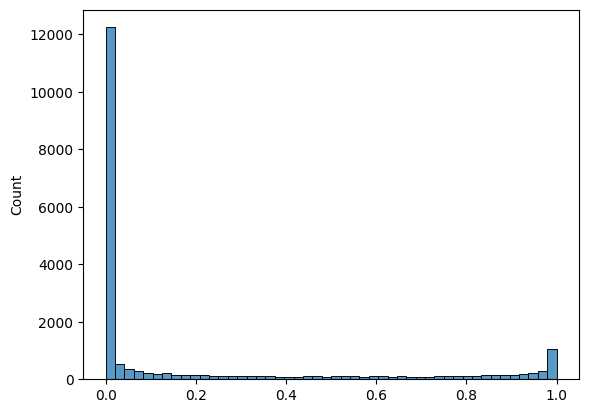

In [7]:
sns.histplot(W_hit)

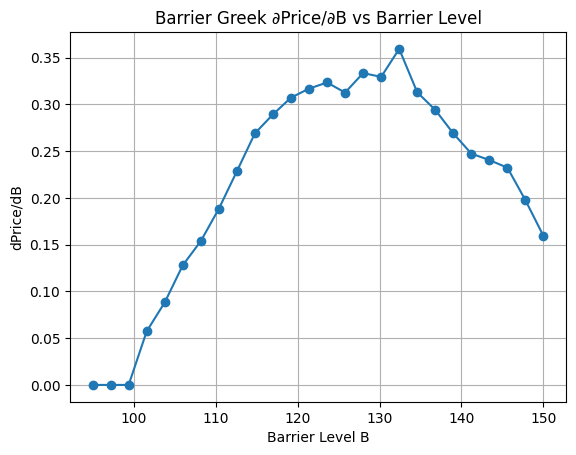

In [8]:
# Sweep of barrier levels
B_values = np.linspace(95, 150, 26)

dB_values = []
for B in B_values:
    _, greeks, _, max_path, _ = fx_barrier_mc_tang_bb(
        S0=100,
        times=np.linspace(0,1,50),
        T=1.0,
        K=100,
        B=B,
        r=0.05,
        sigma=0.2,
        Nsim=5000
    )
    dB_values.append(greeks['dB'])

# Plot
plt.plot(B_values, dB_values, marker='o')
plt.xlabel('Barrier Level B')
plt.ylabel('dPrice/dB')
plt.title('Barrier Greek ∂Price/∂B vs Barrier Level')
plt.grid(True)
plt.show()

Comparing if theoretical continuous density p(sup 0<=s<=T Ss)(x) * (x-K) lines up with the dV/dB calculated above, where for simplicity we assume that the payoff conditional on the max being x is x-100

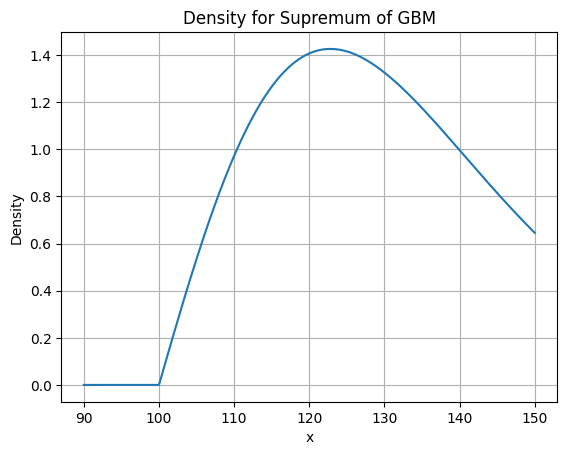

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def density_sup_gbm(x, S0, mu, sigma, T):
    """Calculates the density of the supremum of a GBM."""
    term1 = (2 / (x * sigma * np.sqrt(T*np.pi)))*np.exp(-(np.log(x/S0)-(mu-1/2*sigma**2)*T)**2/(2*sigma**2*T))
    return np.where(x>S0, 2*term1, 0)

# Set parameters
S0 = 100
mu = 0.05
sigma = 0.2
T = 1

# Create x values
x_values = np.linspace(90, 150, 1000)  # Avoid x=0 for log calculation

# Calculate density and density*x
density_values = density_sup_gbm(x_values, S0, mu, sigma, T)
density_times_x = density_values * (x_values-100)

# Plot
plt.plot(x_values, density_times_x)
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density for Supremum of GBM')
plt.grid(True)
plt.show()

# 2c) FX Barrier Price and Greeks using Monte Carlo with Backward Mode and Smoothing of the Barrier Condition

I chose a low smooth_alpha to capture more values below the barrier to reduce variance especially for large barriers. I chose a variation of the sigmoid function     

    smooth = 2*1.0/(1.0 + np.exp(-smooth_alpha*(max_path - B)))

    smooth = np.where(max_path>B, 1, smooth)


because the normal sigmoid is not strictly 1 for max_path>=B. This causes values above the barrier to influence the gradient which I want to avoid. This smooth function is 2*normal sigmoid for max_path<B and 1 for max_path>=B. Example:

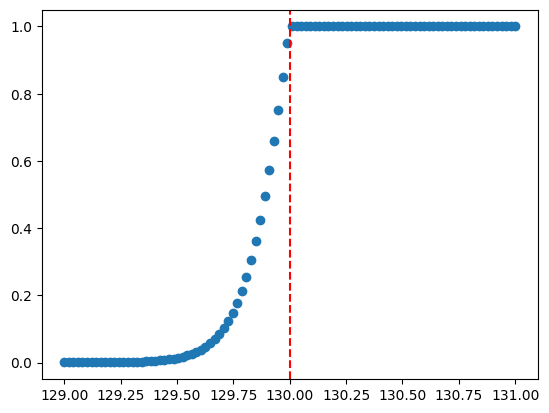

In [10]:
smooth_alpha = 10
B = 130
max_path = np.linspace(129, 131, 100)
smooth = 2*1.0/(1.0 + np.exp(-smooth_alpha*(max_path - B)))
smooth = np.where(max_path>B, 1, smooth)
plt.plot(max_path,smooth,"o")
plt.axvline(x=B, color='r', linestyle='--')

In [11]:
def mc_barrier_pathwise_all(
    S0, times, T, K, B, r, sigma,
    Nsim=10000, option_type="up-and-out", price_b = 1,
    smooth_alpha=10
):
    """
    MC up‑and‑in barrier call pricer with full pathwise tangents and smoothing:
      - delta    = ∂/∂S0
      - rho      = ∂/∂r
      - vega     = ∂/∂σ
      - strike‑delta = ∂/∂K
      - barrier‑delta = ∂/∂B via smoothed indicator
    Returns: price, {dS0, dr, dsigma, dK, dB}
    """
    M  = len(times)
    t0 = times[0]
    h  = (T - t0)/(M-1)

    # 1) simulate Brownian increments
    dW = np.random.normal(0, np.sqrt(h), size=(Nsim, M-1))

    # 2) allocate arrays
    S = np.zeros((Nsim, M))
    S_b = np.zeros((Nsim, M))
    A = np.zeros_like(dW)
    A_b = np.zeros_like(dW)
    Mfac = np.zeros_like(dW)
    Mfac_b = np.zeros_like(dW)
    sigma_b = 0.0
    r_b = 0.0
    h_b = 0.0
    t0_b = 0.0

    # 3) initial conditions
    S[:,0] = S0

    # 4) forward loop
    for i in range(M-1):
        A[:,i] = (r - 0.5*sigma**2)*h + sigma*dW[:,i]
        Mfac[:,i] = np.exp(A[:,i])
        S[:,i+1] = S[:,i] * Mfac[:,i]

    max_path = S.max(axis=1)
    argmax_idx = S.argmax(axis=1)

    # 5) smoothed barrier indicator
    smooth = 2*1.0/(1.0 + np.exp(-smooth_alpha*(max_path - B)))
    smooth = np.where(max_path>B, 1, smooth)
# Generalized knocked calculation
    if option_type == "up-and-in":
        knocked = smooth
        dknock_dmax = 2 * smooth_alpha * smooth * (1 - smooth)  # Derivative below barrier
    else:
        knocked = 1 - smooth
        dknock_dmax = -2 * smooth_alpha * smooth * (1 - smooth)  # Negate for down-and-out

    # No gradient above the barrier
    dknock_dmax = np.where(max_path > B, 0, dknock_dmax)

    # Derivative with respect to the barrier
    dknock_dB = -dknock_dmax

    S_T = S[:,-1]
    I_K = (S_T > K).astype(float)
    payoff = knocked * np.maximum(S_T - K, 0.0)

    # 6) discount & price
    disc  = np.exp(-r*(T - t0))
    price = disc * payoff.mean()

    ############# Backward Sweep ################
    disc_b = payoff.mean() * price_b
    payoff_b = disc * 1.0/len(payoff) * price_b
    price_b = 0.0

    # discount sensitivities
    r_b = -(T-t0) * disc * disc_b
    t0_b = r * disc * disc_b
    disc_b = 0.0

    # payoff sensitivities
    knocked_b = np.maximum(S_T - K, 0.0) * payoff_b
    S_T_b = knocked * I_K * payoff_b
    K_b = -knocked * I_K * payoff_b
    payoff_b = 0.0
    S_b[:,-1] = S_T_b

    # barrier smoothing sensitivities
    # accumulate wrt B
    B_b = np.sum(knocked_b * dknock_dB)
    # accumulate wrt max_path and propagate to S
    #max_b = knocked_b * dknock_dmax
    #S_b[np.arange(Nsim), argmax_idx] += max_b

    # propagate through time steps
    for i in reversed(range(M-1)):
        # S[:,i+1] = S[:,i] * Mfac[:,i]
        Mfac_b[:,i] += S[:, i] * S_b[:, i+1]
        S_b[:, i] += Mfac[:, i] * S_b[:, i+1]
        # Mfac = exp(A)
        A_b[:,i] += Mfac[:, i] * Mfac_b[:,i]
        # A = (r-0.5σ²)*h + σ dW
        r_b += np.sum(A_b[:,i]) * h
        # vega: two contributions
        sigma_b += np.sum(A_b[:,i] * dW[:, i])
        sigma_b += np.sum(A_b[:,i] * (-sigma * h))
        h_b += np.sum(A_b[:,i] * (r - 0.5*sigma**2))

    t0_b += -h_b/(M-1)

    greeks = {
        "dS0":    np.sum(S_b[:,0]),
        "dr":     r_b,
        "dsigma": sigma_b,
        "dt":     t0_b,
        "dK":     np.sum(K_b),
        "dB":     B_b,
    }


    return smooth, max_path, price, greeks


In [12]:
times = np.linspace(0, 1, 11)
times = [0.9,1]
smooth, max_path, price2, greeks = mc_barrier_pathwise_all(S0=110, times=times, T=1.0, K=100, B=180, r=0.05, sigma=0.2, Nsim=10000)
#plt.plot(max_path, smooth
#sns.scatterplot(x=max_path, y=smooth)
greeks

{'dS0': np.float64(0.9503842462620041),
 'dr': np.float64(9.386947728703761),
 'dsigma': np.float64(3.6530509230994634),
 'dt': np.float64(-2.602628522575473),
 'dK': np.float64(-0.9386947728703763),
 'dB': np.float64(3.4543324161932536e-171)}

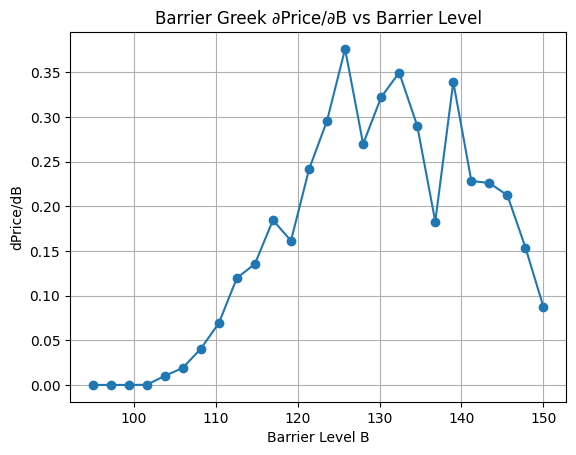

In [13]:
# Sweep of barrier levels
B_values = np.linspace(95, 150, 26)

dB_values = []
for B in B_values:
    _,max_path,_, greeks = mc_barrier_pathwise_all(
        S0=100,
        times=np.linspace(0,1,100),
        T=1.0,
        K=100,
        B=B,
        r=0.05,
        sigma=0.2,
        Nsim=10000
    )
    dB_values.append(greeks['dB'])

# Plot
plt.plot(B_values, dB_values, marker='o')
plt.xlabel('Barrier Level B')
plt.ylabel('dPrice/dB')
plt.title('Barrier Greek ∂Price/∂B vs Barrier Level')
plt.grid(True)
plt.show()

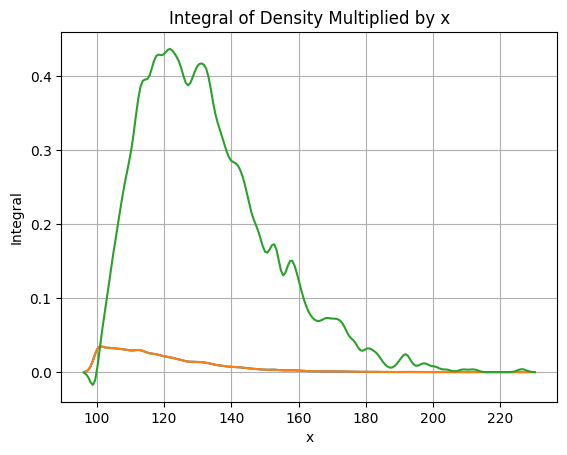

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Assuming max_path is already calculated
x_values = max_path #np.where(max_path > 100, max_path-100, 0)

# Estimate the density using Kernel Density Estimation (KDE)
density = sns.kdeplot(x_values, bw_adjust=0.5).get_lines()[0].get_data()[1]
x_axis = sns.kdeplot(x_values, bw_adjust=0.5).get_lines()[0].get_data()[0]

# Multiply density by x
density_times_x = density * (x_axis-100)

# Define a function for integration
def integrand(x):
    # Interpolate the density at the given x-value
    density_at_x = np.interp(x, x_axis, density)
    return density_at_x * x

# Calculate the integral using quad
# integral_values = [quad(integrand, x_axis[0], x)[0] for x in x_axis]

# # Plot the integral
plt.plot(x_axis, density_times_x)
plt.xlabel('x')
plt.ylabel('Integral')
plt.title('Integral of Density Multiplied by x')
plt.grid(True)
plt.show()

Below is the same function as above, but only returning the relevant market greeks.

In [15]:
def mc_fx_barrier_backward(
    S0, times, T, K, B, r, sigma,
    Nsim=20000, option_type="up-and-out", price_b = 1,
    smooth_alpha=1
):
    """
    Same function as above but only returning the relevant market greeks
    MC up‑and‑in barrier call pricer with full pathwise tangents and smoothing:
      - delta    = ∂/∂S0
      - rho      = ∂/∂r
      - vega     = ∂/∂σ
    Returns: price, {dS0, dr, dsigma}
    """

    #this ensures a simulation time grid that is proportional to the time left to maturity, plus 2 time steps to avoid issues at very small TTM
    M  = len(times)+2
    t0 = times[0]
    h  = (T - t0)/(M-1)

    # 1) simulate Brownian increments
    dW = np.random.normal(0, np.sqrt(h), size=(Nsim, M-1))

    # 2) allocate arrays
    S = np.zeros((Nsim, M))
    S_b = np.zeros((Nsim, M))
    A = np.zeros_like(dW)
    A_b = np.zeros_like(dW)
    Mfac = np.zeros_like(dW)
    Mfac_b = np.zeros_like(dW)
    sigma_b = 0.0
    r_b = 0.0
    h_b = 0.0
    t0_b = 0.0

    # 3) initial conditions
    S[:,0] = S0

    # 4) forward loop
    for i in range(M-1):
        A[:,i] = (r - 0.5*sigma**2)*h + sigma*dW[:,i]
        Mfac[:,i] = np.exp(A[:,i])
        S[:,i+1] = S[:,i] * Mfac[:,i]

    max_path = S.max(axis=1)
    knocked = (max_path <= B).astype(float)
    S_T = S[:,-1]
    I_K = (S_T > K).astype(float)
    payoff = knocked * np.maximum(S_T - K, 0.0)

    disc  = np.exp(-r*(T - t0))
    price = disc * payoff.mean()

    ############# Backward Sweep ################
    disc_b = payoff.mean() * price_b
    payoff_b = disc * 1.0/len(payoff) * price_b
    price_b = 0.0

    # discount sensitivities
    r_b = -(T-t0) * disc * disc_b
    t0_b = r * disc * disc_b
    disc_b = 0.0

    # payoff sensitivities
    knocked_b = np.maximum(S_T - K, 0.0) * payoff_b
    S_T_b = knocked * I_K * payoff_b
    K_b = -knocked * I_K * payoff_b
    payoff_b = 0.0
    S_b[:,-1] = S_T_b

    # barrier smoothing sensitivities
    # accumulate wrt B
    # accumulate wrt max_path and propagate to S
    #max_b = knocked_b * dknock_dmax
    #S_b[np.arange(Nsim), argmax_idx] += max_b

    # propagate through time steps
    for i in reversed(range(M-1)):
        # S[:,i+1] = S[:,i] * Mfac[:,i]
        Mfac_b[:,i] += S[:, i] * S_b[:, i+1]
        S_b[:, i] += Mfac[:, i] * S_b[:, i+1]
        # Mfac = exp(A)
        A_b[:,i] += Mfac[:, i] * Mfac_b[:,i]
        # A = (r-0.5σ²)*h + σ dW
        r_b += np.sum(A_b[:,i]) * h
        # vega: two contributions
        sigma_b += np.sum(A_b[:,i] * dW[:, i])
        sigma_b += np.sum(A_b[:,i] * (-sigma * h))
        h_b += np.sum(A_b[:,i] * (r - 0.5*sigma**2))


    greeks = {
        "dS0":    np.sum(S_b[:,0]),
        "dr":     r_b,
        "dsigma": sigma_b
    }


    return price, greeks


In [16]:
times = np.linspace(0, 1, 11)
#times = [, 1]
price2, greeks = mc_fx_barrier_backward(S0=110, times=times, T=1.0, K=100, B=180, r=0.03, sigma=0.1, Nsim=20000)
#plt.plot(max_path, smooth
#sns.scatterplot(x=max_path, y=smooth)
greeks#['dsigma']

{'dS0': np.float64(0.9041462766512278),
 'dr': np.float64(85.97176981706231),
 'dsigma': np.float64(18.837465656374917)}

# 3) Putting it together: Generate paths, calculate prices and greeks, aggregate, calculate risk metrics

## Backward

In this base case for market and product data, we set the correlation between equity and FX asset to 0.8.

In [25]:
market_data = {
    'mu': [0.08, 0.02],        # drifts for equity, FX
    'sigma': [0.20, 0.10],     # volatilities
    'rho': 0.8,                # correlation between equity and FX
    'X0': [100.0, 100],        # initial values for equity and FX
    'T': 1.0,                  # time horizon
    'Nsteps': 101,             # number of steps
    'Npaths': 1000,            # number of paths
    'vasicek_a': 0.1,          # Vasicek mean reversion speed
    'vasicek_b': 0.03,         # Vasicek long-term mean
    'vasicek_sigma_r': 0.01,   # Vasicek volatility
    'vasicek_r0': 0.03         # Vasicek initial rate
}

product_data = {
    'eq_call':
    {
    'eq_call_strike': 100
    },
    'fx_barrier_call':
    {
    'fx_call_strike': 100,
    'fx_call_barrier': 250
    }
}


def simulate_rfe(market_data: dict):
    mu = market_data['mu']
    sigma = market_data['sigma']
    rho = market_data['rho']
    X0 = market_data['X0']
    T = market_data['T']
    Nsteps = market_data['Nsteps']
    Npaths = market_data['Npaths']

    S, FX = simulate_gbm_fx_eq(mu, sigma, rho, X0, T, Nsteps, Npaths)
    r = simulate_vasicek(
        a=market_data['vasicek_a'],
        b=market_data['vasicek_b'],
        sigma_r=market_data['vasicek_sigma_r'],
        r0=market_data['vasicek_r0'],
        T=T, Nsteps=Nsteps, Npaths=Npaths
    )

    # Include metadata for pricing
    return {'S': S, 'FX': FX, 'r': r, 'T': T, 'Nsteps': Nsteps, 'Npaths': Npaths, 'sigma': sigma}


def price_portfolio_b(product_data: dict, rfe: dict):
    S = rfe['S']            # (timesteps+1, Npaths)
    FX = rfe['FX']          # (timesteps+1, Npaths)
    r  = rfe['r']           # (timesteps+1, Npaths)
    T  = rfe['T']
    Nsteps = rfe['Nsteps']
    Npaths = rfe['Npaths']
    sigma_eq, sigma_fx = rfe['sigma']

    prices = {}
    greeks = {}
    # Precompute barrier crossing: True once FX >= barrier
    times = np.linspace(0, T, Nsteps)
    idxs  = np.linspace(0, Nsteps-1, 11, dtype=int)
    for product in product_data:
        greeks[product] = {}
        if product == 'eq_call':
    # Equity call via BS at the 10 cut-out times
          times_short = times[idxs]         # (10,)
          T_short    = times_short[-1]
          S_short = S[:, idxs]         # (Npaths, 10)
          r_short = r[:, idxs]         # (Npaths, 10)
          print(f"Computing equity calls...")
          eq_vals, gr = bs_call_backward(
              S=S_short, times=times_short, T=T_short,
              K=product_data[product]['eq_call_strike'], r=r_short,
              sigma=sigma_eq, C_b=1
          )  # (Npaths, 10)
          gr = {name: mat.T for name, mat in gr.items()}
          greeks[product] = gr
          prices[product] = eq_vals.T            # (10, Npaths)
          print(f"Equity Call pricing complete. \nSample first path: {prices[product][:,0]} \nSample first underlying: {S_short[0,:]}")
        elif product == 'fx_barrier_call':
          B = product_data[product]['fx_call_barrier']
          barrier_hit = np.cumsum(FX >= B, axis=1) > 0  # (timesteps+1, Npaths)
          # FX barrier call via MC, with knock-out
          greeks[product] = {"dS0": np.zeros((len(idxs), Npaths)), "dr": np.zeros((len(idxs), Npaths)), "dsigma": np.zeros((len(idxs), Npaths))}
          fx_prices = np.zeros((len(idxs), Npaths))
          print(f"\n\nComputing FX barriers...")

          for i, idx in enumerate(idxs):
              t0        = times[idx]
              T_rem     = T - t0
              times_sub = times[idx:] - t0      # vector of remaining times
              FX0       = FX[:, idx]           # (Npaths,)
              r_sub     = r[:, idx]           # (remaining_steps+1, Npaths)
              print(f"----- Outer loop i={i}, time idx={idx}, t0={t0:.2f} -----")
              for j in range(Npaths):
                  if barrier_hit[j, idx]:
                      fx_prices[i, j] = 0.0
                  else:
                      price, gr = mc_fx_barrier_backward(
                          S0=FX0[j], times=times_sub, T=T_rem,
                          K=product_data[product]['fx_call_strike'], B=B,
                          r=r_sub[j], sigma=sigma_fx,
                          Nsim=product_data.get('fx_mc_nsim', 2000),
                          option_type=product_data.get('fx_option_type','up-and-out'),
                          price_b=product_data.get('fx_price_b',1),
                          smooth_alpha=product_data.get('fx_smooth_alpha',10)
                      )
                      fx_prices[i, j] = price
                      greeks[product]["dS0"][i, j] = gr["dS0"]
                      greeks[product]["dr"][i, j] = gr["dr"]
                      greeks[product]["dsigma"][i, j] = gr["dsigma"]
              prices[product] = fx_prices          # (10, Npaths)
              print(f"Completed FX pricing at i={i}, t0={t0:.2f}. Sample price first path: {fx_prices[i,0]:.2f}. Underlying: {FX[0,idx]:.2f}")
          print("\n\nAll FX pricing loops complete.\n\n")

        else:
            raise ValueError(f"Unknown product: {product}")


    return prices, greeks

def aggregate_prices(prices: dict):
    portfolio_values = None
    for product, price_matrix in prices.items():
        if portfolio_values is None:
            portfolio_values = price_matrix
        else:
            # Ensure dimensions match before adding
            if portfolio_values.shape != price_matrix.shape:
                raise ValueError(f"Price matrix for product '{product}' has unexpected shape.")
            portfolio_values += price_matrix

    # If the prices dictionary was empty
    if portfolio_values is None:
        # Return an empty array or an array with the expected shape, depending on your use case
        # Here, we assume an empty matrix can be returned
        return np.array([[]])
    else:
        return portfolio_values


def aggregate_prices_b(prices: dict, portfolio_values: dict, portfolio_values_b=None):
    prices_b = {}
    # If the prices dictionary was empty
    if (portfolio_values is not None) and (prices is not None) and (portfolio_values_b is not None):
        for product in prices:
            prices_b[product] = {}
            for risk_metric in portfolio_values_b:
              prices_b[product][risk_metric] = portfolio_values_b[risk_metric]

    return prices_b


# vectorized erf for arrays
vec_erf = np.vectorize(math.erf)

def density_quantile_and_gradients(portfolio_values, p=0.95, bw_factor=0.15, tol=1e-6, maxiter=50):
    """
    KDE-based quantile and gradients with adjustable bandwidth.

    Parameters
    ----------
    portfolio_values : np.ndarray, shape (T, N)
    p : float
        Quantile level.
    bw_factor : float
        Factor to scale Silverman bandwidth (bw_factor < 1 -> stricter smoothing).
    tol : float
    maxiter : int

    Returns
    -------
    q_hat : np.ndarray, shape (T,)
    grad : np.ndarray, shape (T, N)
    """
    T, N = portfolio_values.shape
    q_hat = np.zeros(T)
    grad = np.zeros_like(portfolio_values)

    for t in range(T):
        x = portfolio_values[t]
        # Adjust Silverman's rule by bw_factor
        h = bw_factor * (1.06 * np.std(x, ddof=1) * N**(-1/5))

        # KDE-based CDF
        def F_hat(q):
            z = (q - x) / (h * math.sqrt(2))
            return np.mean(0.5 * (1 + vec_erf(z)))

        # Bracket for quantile
        a, b = x.min(), x.max()
        fa, fb = F_hat(a), F_hat(b)
        if fa > p or fb < p:
            raise ValueError(f"No bracket for t={t}")

        # Bisection search
        for _ in range(maxiter):
            m = 0.5 * (a + b)
            fm = F_hat(m)
            if abs(fm - p) < tol:
                break
            if fm < p:
                a = m
            else:
                b = m

        q = 0.5 * (a + b)
        q_hat[t] = q

        # Estimate density at q
        z = (q - x) / (h * math.sqrt(2))
        phi = np.exp(-z**2) / (math.sqrt(2 * math.pi) * h)
        f_q = np.mean(phi)

        # Pathwise gradient
        grad[t] = phi / (N * f_q)

    return q_hat, grad

def compute_risk_metrics_b(portfolio_values: np.ndarray, risk_metrics_b=None):
    """
    Compute expected exposure metrics and pathwise gradients,
    using KDE-based quantile smoothing (bw_factor=0.15).
    """
    if risk_metrics_b is None:
        risk_metrics_b = {"mean_price_b": 1, "95_quantile_b": 1}

    # portfolio_values: shape (T, N)
    T, N = portfolio_values.shape

    # Forward: mean price
    mean_price = np.mean(portfolio_values, axis=1)

    # Forward+Backward: smooth 95%-quantile and its gradients
    quantile_smooth, grad_quantile = density_quantile_and_gradients(
        portfolio_values, p=0.95, bw_factor=0.1
    )

    # Backward: mean gradient
    mean_b = risk_metrics_b["mean_price_b"]
    grad_mean = np.full_like(portfolio_values, mean_b / N)

    # Backward: quantile gradient scaled by incoming signal
    quantile_b = risk_metrics_b["95_quantile_b"]
    grad_quantile *= quantile_b

    risk_metrics = {
        "mean_price": mean_price,
        "95_quantile": quantile_smooth
    }

    portfolio_values_b = {
        "mean_price_b": grad_mean,
        "95_quantile_b": grad_quantile
    }

    return risk_metrics, portfolio_values_b


def compute_greek_b(greeks: dict, prices_b: dict):
    """
    Reorganize and aggregate pathwise sensitivities so that the output dict has the form
      greek_name -> risk_metric -> vector of length T

    greeks: dict of form
      greeks[product][greek_name] = array of shape (T, N)
    prices_b: dict of form
      prices_b[product][risk_metric] = array of shape (T, N)

    Returns
    -------
    greek_b: dict of form
      greek_b[greek_name][risk_metric] = array of shape (T,)
    where for each greek and each metric we sum over products and over paths.
    """
    greek_b = {}

    for product, metrics in prices_b.items():
        greek_b[product] = {}
        # Grees und Preise müssen pro Produkt die gleiche Shape (T, N) haben
        for greek_name, greek_mat in greeks[product].items():
            # Wir initialisieren alle risk_metrics mit Null-Vektor
            greek_b[product][greek_name] = {}
            for metric, grad_M in metrics.items():  # grad_M shape (T, N)
                # Pfadsumme pro Zeitschritt
                contrib = np.sum(greek_mat * grad_M, axis=1)  # shape (T,)
                greek_b[product][greek_name][metric] = contrib

    return greek_b




def simulate_b(market_data: dict, product_data: dict):
  rfe = simulate_rfe(market_data)

  #grab prices and greeks in one sweep
  prices, greeks = price_portfolio_b(product_data, rfe)

  #aggregate prices
  portfolio_values = aggregate_prices(prices)

  #grab risk metrics and the portfolio_values adjoint int one go
  risk_metrics, portfolio_values_b = compute_risk_metrics_b(portfolio_values)

  #calculate the price adjoints
  prices_b = aggregate_prices_b(prices, portfolio_values, portfolio_values_b)

  #calculate the market_data adjoints based on price adjoints and greeks from above
  greeks_b = compute_greek_b (greeks, prices_b)

  return greeks_b, portfolio_values, portfolio_values_b, risk_metrics

g, portfolio_values, portfolio_values_b, risk_metrics = simulate_b(market_data, product_data)
g

Computing equity calls...
Equity Call pricing complete. 
Sample first path: [ 9.41340338  9.61384162 11.13937853  5.4255044   5.01465985  4.38187193
  7.96634431  3.31261066  2.47222824  2.10624719  0.        ] 
Sample first underlying: [100.         101.33430865 105.00542793  96.2134218   96.37528631
  96.19240046 103.80950709  96.9025497   97.04574494  98.8410952
  93.64501498]


Computing FX barriers...
----- Outer loop i=0, time idx=0, t0=0.00 -----
Completed FX pricing at i=0, t0=0.00. Sample price first path: 5.58. Underlying: 100.00
----- Outer loop i=1, time idx=10, t0=0.10 -----
Completed FX pricing at i=1, t0=0.10. Sample price first path: 6.26. Underlying: 101.71
----- Outer loop i=2, time idx=20, t0=0.20 -----
Completed FX pricing at i=2, t0=0.20. Sample price first path: 8.54. Underlying: 105.52
----- Outer loop i=3, time idx=30, t0=0.30 -----
Completed FX pricing at i=3, t0=0.30. Sample price first path: 3.34. Underlying: 98.48
----- Outer loop i=4, time idx=40, t0=0.40 -

{'eq_call': {'dS0': {'mean_price_b': array([0.59870633, 0.60003708, 0.60073872, 0.60080269, 0.60510049,
          0.60564722, 0.60048834, 0.60391325, 0.59908556, 0.5992552 ,
          0.611     ]),
   '95_quantile_b': array([0.59870633, 0.78402168, 0.88235223, 0.90674889, 0.94507721,
          0.97682521, 0.99476442, 0.99733617, 0.9998638 , 0.99999581,
          1.        ])},
  'dr': {'mean_price_b': array([50.45722918, 46.37354208, 42.00193697, 37.38729861, 32.83441502,
          27.89356795, 22.4833514 , 17.2484583 , 11.60323487,  5.89884488,
           0.        ]),
   '95_quantile_b': array([50.45722918, 63.49718499, 65.69414279, 60.02765256, 54.54813265,
          47.61132988, 39.21038573, 29.56700153, 19.87597057,  9.96705603,
           0.        ])},
  'dsigma': {'mean_price_b': array([38.66681168, 34.79031662, 31.06492728, 27.40523583, 23.79380438,
          19.5730623 , 15.72339009, 11.86644821,  7.70192345,  3.79609989,
           0.        ]),
   '95_quantile_b': array([3.

Correlation = -1

In [26]:
market_data['rho'] = -0.8
g2, portfolio_values, portfolio_values_b, risk_metrics = simulate_b(market_data, product_data)
g2

Computing equity calls...
Equity Call pricing complete. 
Sample first path: [ 9.41340338 10.0252069   6.91176017  9.43716487 11.2143005   4.11573545
  5.31789748  6.71667805  1.0122735   2.93450709  0.        ] 
Sample first underlying: [100.         101.68429128  97.05178761 102.28729552 106.00377066
  95.18620275  99.17648986 103.07561296  92.4411253  100.47292115
  94.2201881 ]


Computing FX barriers...
----- Outer loop i=0, time idx=0, t0=0.00 -----
Completed FX pricing at i=0, t0=0.00. Sample price first path: 5.39. Underlying: 100.00
----- Outer loop i=1, time idx=10, t0=0.10 -----
Completed FX pricing at i=1, t0=0.10. Sample price first path: 3.22. Underlying: 96.53
----- Outer loop i=2, time idx=20, t0=0.20 -----
Completed FX pricing at i=2, t0=0.20. Sample price first path: 5.05. Underlying: 99.83
----- Outer loop i=3, time idx=30, t0=0.30 -----
Completed FX pricing at i=3, t0=0.30. Sample price first path: 5.23. Underlying: 100.29
----- Outer loop i=4, time idx=40, t0=0.40 -

{'eq_call': {'dS0': {'mean_price_b': array([0.59870633, 0.60247809, 0.60750697, 0.61099105, 0.61357262,
          0.61917817, 0.61692317, 0.61763338, 0.62716191, 0.62627569,
          0.628     ]),
   '95_quantile_b': array([0.59870633, 0.77248047, 0.86458893, 0.92230981, 0.96059347,
          0.98315943, 0.99441675, 0.9988569 , 0.99995795, 1.        ,
          1.        ])},
  'dr': {'mean_price_b': array([50.45722918, 46.57813453, 42.55729034, 38.13687508, 33.42579812,
          28.6172786 , 23.19739478, 17.70730919, 12.18121942,  6.1746301 ,
           0.        ]),
   '95_quantile_b': array([50.45722918, 62.21749686, 64.19395662, 61.42770805, 55.8344152 ,
          48.11317994, 39.07578771, 29.70165874, 19.87007892,  9.97185232,
           0.        ])},
  'dsigma': {'mean_price_b': array([38.66681168, 34.90555294, 31.00330303, 27.12106026, 23.05676166,
          19.03918161, 14.96401997, 10.99579104,  7.22325249,  3.4753234 ,
           0.        ]),
   '95_quantile_b': array([3.

Correlation = 0

In [24]:
market_data['rho'] = 0
g3, portfolio_values, portfolio_values_b, risk_metrics = simulate_b(market_data, product_data)
g3

Computing equity calls...
Equity Call pricing complete. 
Sample first path: [ 9.41340338 15.41787358  8.56224763  7.19365424 12.0462293  13.25233863
  7.16229561  4.30897407  2.63342071  2.05443326  1.83962587] 
Sample first underlying: [100.         109.18366399 100.03881615  98.68856049 107.02041902
 109.73738489 102.46537346  99.01229054  97.51227446  98.71765134
 101.83962587]


Computing FX barriers...
----- Outer loop i=0, time idx=0, t0=0.00 -----
Completed FX pricing at i=0, t0=0.00. Sample price first path: 5.77. Underlying: 100.00
----- Outer loop i=1, time idx=10, t0=0.10 -----
Completed FX pricing at i=1, t0=0.10. Sample price first path: 4.16. Underlying: 97.75
----- Outer loop i=2, time idx=20, t0=0.20 -----
Completed FX pricing at i=2, t0=0.20. Sample price first path: 1.57. Underlying: 92.43
----- Outer loop i=3, time idx=30, t0=0.30 -----
Completed FX pricing at i=3, t0=0.30. Sample price first path: 4.74. Underlying: 99.86
----- Outer loop i=4, time idx=40, t0=0.40 --

{'eq_call': {'dS0': {'mean_price_b': array([0.59870633, 0.60658259, 0.61025682, 0.60578045, 0.61529924,
          0.61885473, 0.62657674, 0.61524681, 0.61510911, 0.62673927,
          0.63      ]),
   '95_quantile_b': array([0.59870633, 0.8046177 , 0.86538615, 0.88607113, 0.94722045,
          0.96822698, 0.98231943, 0.99840996, 0.99975191, 0.9999915 ,
          1.        ])},
  'dr': {'mean_price_b': array([50.45722918, 46.94791202, 42.78568727, 37.77905071, 33.50362139,
          28.57057106, 23.55251092, 17.59642639, 11.91783888,  6.17301985,
           0.        ]),
   '95_quantile_b': array([50.45722918, 65.54306441, 64.31226831, 58.35422833, 54.79235538,
          47.12236409, 38.58115826, 29.68493936, 19.87414895,  9.97411681,
           0.        ])},
  'dsigma': {'mean_price_b': array([38.66681168, 34.81743986, 30.81984166, 27.0012455 , 23.20912198,
          19.27626762, 15.2678599 , 11.66149382,  7.80308866,  3.79654451,
           0.        ]),
   '95_quantile_b': array([3.

As we can see, changing correlation has an effect on the sensitivities of the 95% quantile, but not the mean. This makes sense, since the mean is a linear statistic and for that we only care about marginal distributions which are unaffected by a change in correlation.

If we have a strong positive correlation of 0.8, the simulated portfolio values in the 95% quantile will typically consist of a ITM FX barrier call and an ITM equity call, so each greek will be that of an ITM option (i.e. near 1 for dS0).

If we have a strong negative correlation of -0.8, the simulated portfolio values in the 95% quantile will typically consist of the ITM option which has nominally larger 95% quantile values and an OTM option of the other type. In this case, the equity option is ITM and therefore its greeks are those of an ITM call, and the FX barrier call has OTM greeks.

In case of 0 correlation, again the nominally larger asset dominates, so it has ITM greeks, but the Greeks of the nominally smaller assets are a mix between ITM and OTM.




### Example of Gradient smoothing of 95% Quantile

This code exemplifies how the density based gradient of the 95% quantile and the 'hard' gradient differ. Since we deal with a lot of variance in our MC simulation, it is better to smooth the gradient around the 95% quantile

In [18]:
def add_hard_quantile_gradient(df, value_col='sorted_values', grad_col='quantile_grad', p=0.95):
    """
    Computes hard quantile gradients for level p, independent of current ordering.
    After computing, resorts df by density-gradient (column 'sorted_grad_95_quantile') descending.
    """
    # 1) Copy and sort by the value column
    df_copy = df.copy()
    df_sorted = df_copy.sort_values(by=value_col)

    # 2) Compute hard quantile gradient on sorted values
    x = df_sorted[value_col].to_numpy()
    N = len(x)
    pos = p * (N - 1)
    i0 = int(np.floor(pos))
    i1 = int(np.ceil(pos))
    w  = pos - i0

    grad = np.zeros(N)
    grad[i0] = 1 - w
    grad[i1] = w
    df_sorted[grad_col] = grad

    # 3) Restore order by density gradient descending
    df_final = df_sorted.sort_values(by='sorted_grad_95_quantile', ascending=False)
    return df_final


vals = portfolio_values[-1]
grads = portfolio_values_b['95_quantile_b'][-1]

# Get sorting indices
idx = np.argsort(grads)

# Create DataFrame with sorted values and gradients
df = pd.DataFrame({
    'sorted_values': vals[idx],
    'sorted_grad_95_quantile': grads[idx]
})
df_with_grad = add_hard_quantile_gradient(df)
df_with_grad.head(25)

,sorted_values,sorted_grad_95_quantile,quantile_grad
999,69.017063,2.381837e-01,0.95
998,69.627193,1.987786e-01,0.05
997,69.885713,1.406562e-01,0.00
996,68.413626,1.183782e-01,0.00
995,70.098602,9.380026e-02,0.00
994,68.159760,6.795229e-02,0.00
993,70.262417,6.377877e-02,0.00
992,70.504110,3.209752e-02,0.00
991,70.607082,2.295851e-02,0.00
990,67.518573,8.404403e-03,0.00
